# Homework 3



## Discussion of results

Once you are done with the homework, please add a section at the top where you say what you actually found.

## Setup

This section is for imports and such

In [1]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
import pymc as pm
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from google.colab import files
import io

#preliz
!pip install preliz
import preliz as pz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 6.9 MB/s eta 0:00:00


In [2]:
az.style.use("arviz-darkgrid")
sns.set_style("darkgrid")

## 1. Question 1

In [ ]:
def posterior_grid(grid_points=50, heads=6, tails=9):
    """
    A grid implementation for the coin-flipping problem
    """
    grid = np.linspace(0, 1, grid_points)
    prior = pz.Beta(alpha = 20, beta = 20).pdf(grid)
    likelihood = pz.Binomial(n=heads+tails, p=grid).pdf(heads)
    posterior = likelihood * prior
    posterior /= posterior.sum() * (1/grid_points)
    return grid, posterior

/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/dufunc.py:287: RuntimeWarning: divide by zero encountered in nb_logpdf
  return super().__call__(*args, **kws)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

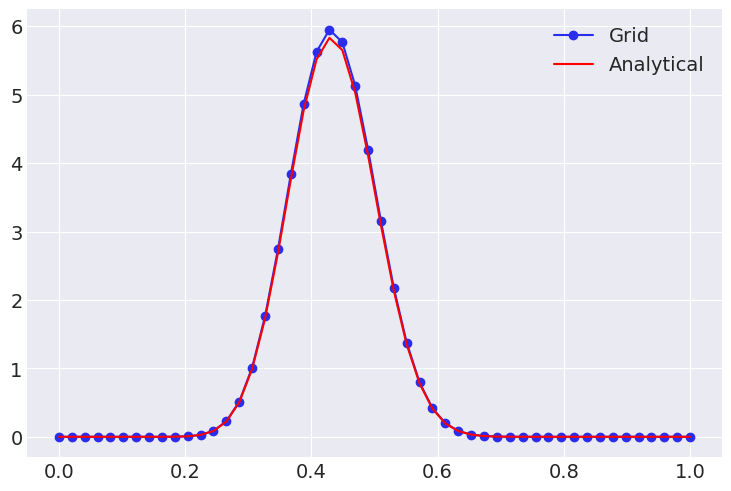

In [ ]:
#data and function call
bernoulli_data = np.repeat([0, 1], (10, 3))
points = 50
h = bernoulli_data.sum()
t = len(bernoulli_data) - h
grid, posterior = posterior_grid(points, h, t)

plt.plot(grid, posterior, 'o-', label = 'Grid')

#analytical
ap = pz.Beta(20 + h, 20 + t).pdf(np.linspace(0, 1, points))
plt.plot(np.linspace(0, 1, points), ap, 'red', label = 'Analytical')


plt.legend(loc = 'upper right')

plt.savefig("coin.png", bbox_inches='tight')
files.download("coin.png")

## 2. Question 2

In [ ]:
#Metropolis Hastings for coin flip
#1. Number of steps
num_steps = 10000
#2. We will choose a random value to initialize theta
current_theta = np.random.rand() #random number between 0-1
#3. We will define the width of our proposal distribution
width = 0.05
#4. Data
num_heads = h
N = h + t

#5. Define our chain
chain = [current_theta]

#6. Run over the steps
for i in range(num_steps):

  #7. Get the proposed theta
  proposed_theta = current_theta + np.random.normal(0, width)

  #8. Get the value proportional to the posterior at each the current and proposed theta
  point_posterior_current = pz.Beta(alpha = 20, beta = 20).pdf(current_theta) * pz.Binomial(n = N, p = current_theta).pdf(num_heads)
  point_posterior_proposed = pz.Beta(alpha = 20, beta = 20).pdf(proposed_theta) * pz.Binomial(n = N, p = proposed_theta).pdf(num_heads)

  #9. Compute the probability of accepting the new position
  pa =  min(1, point_posterior_proposed / point_posterior_current)

  #10. Check if we move or not
  if np.random.rand() < pa:
    current_theta = proposed_theta

  #11. Add the current or proposed value to the chain
  chain.append(current_theta)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

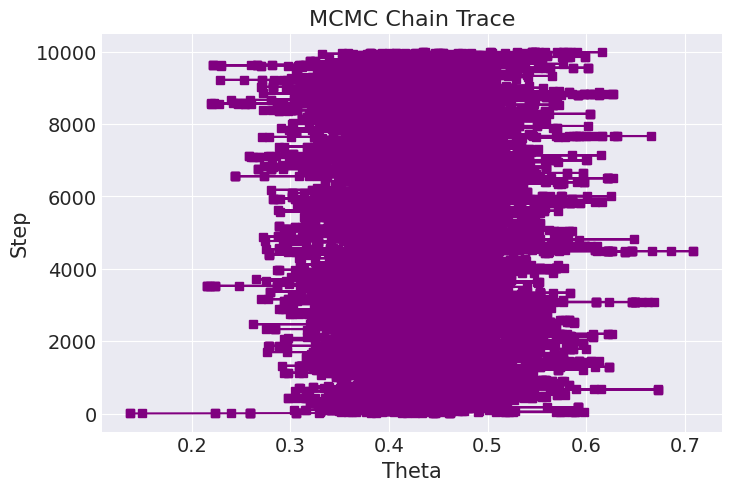

In [ ]:
#Plot the chain
y_positions = np.arange(1, num_steps+2)
plt.plot(chain, y_positions, color='purple', marker='s')

plt.xlabel('Theta')
plt.ylabel('Step')
plt.title('MCMC Chain Trace')

plt.savefig(f"chain{num_steps}.png", bbox_inches='tight')
files.download(f"chain{num_steps}.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

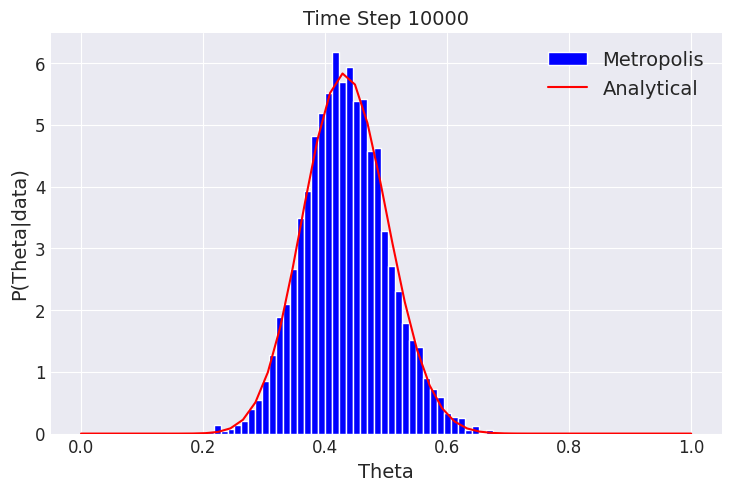

In [ ]:
#Plotting the resulting distribution
plt.hist(chain, bins = 50, density = True, color='blue', label = 'Metropolis')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Theta', fontsize = 14)
plt.ylabel('P(Theta|data)', fontsize = 14)
plt.title(f'Time Step {num_steps}', fontsize = 14)
#plt.ylim([0, 1])
#plt.xlim([0, 1])

plt.plot(np.linspace(0, 1, points), ap, 'red', label = 'Analytical')
plt.legend(loc = 'upper right')


plt.savefig(f"t{num_steps}.png", bbox_inches='tight')
files.download(f"t{num_steps}.png")

## 3. Question 3

In [ ]:
#loading data
data = np.loadtxt("https://github.com/aloctavodia/BAP3/raw/refs/heads/main/code/data/chemical_shifts.csv")


In [ ]:
#writing the model
coords = {"data": np.arange(len(data))}
mu_prior = np.mean(data)
s = np.std(data, ddof = 1)
sig_prior = 3*s

with pm.Model(coords=coords) as model_t:
  m = pm.Normal('m', mu = mu_prior, sigma = sig_prior)
  sig = pm.HalfNormal('sig', sigma = 5)
  n = pm.Exponential('n', 1/10)
  Y = pm.StudentT('Y', nu = n, mu=m, sigma=sig, observed=data, dims = 'data')
  idata_t = pm.sample(1000, chains = 4)

Output()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

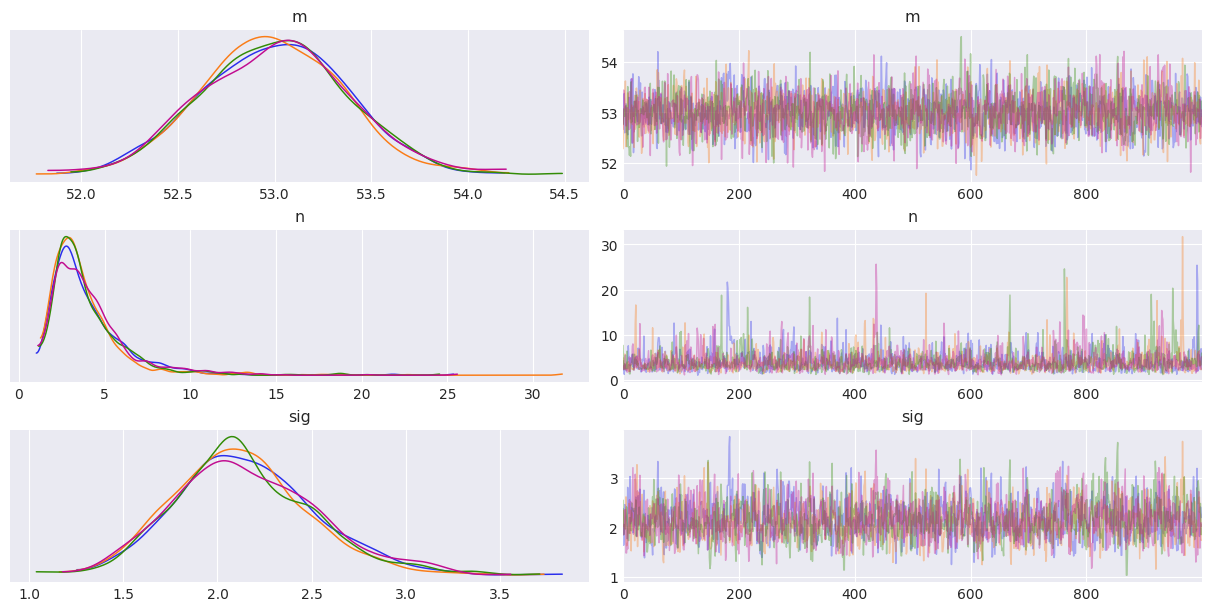

In [ ]:
#trace data
az.plot_trace(idata_t, compact = False)


plt.savefig("trace.png", bbox_inches='tight')
files.download("trace.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

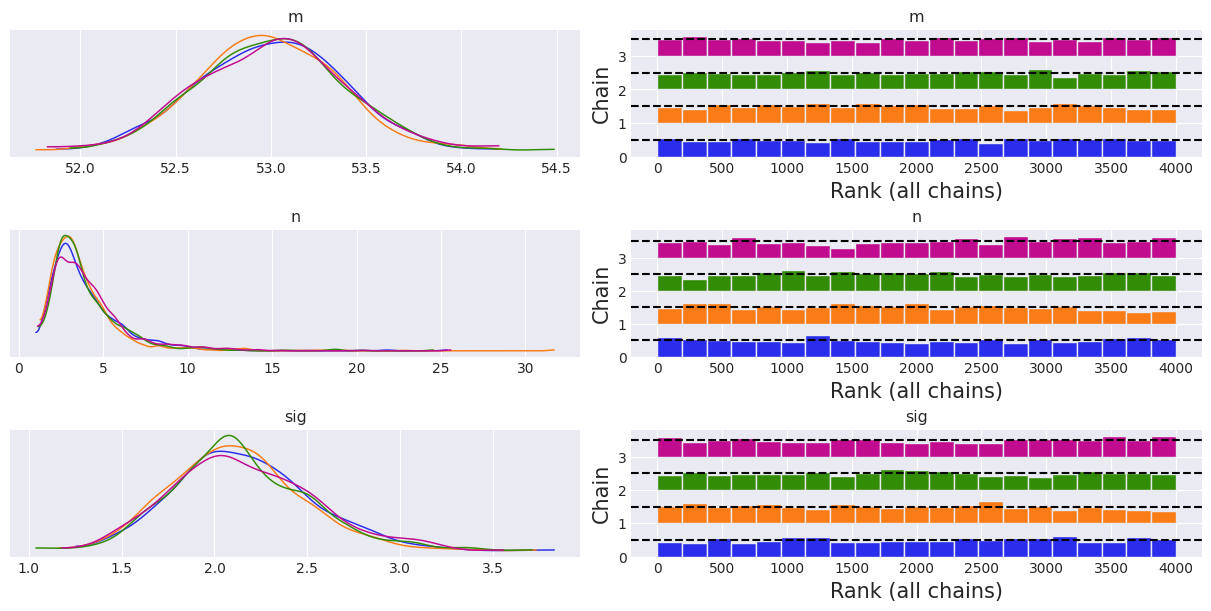

In [ ]:
#rank plot
az.plot_trace(idata_t, kind = 'rank_bars', compact = False)

plt.savefig("rank.png", bbox_inches='tight')
files.download("rank.png")

In [ ]:
#rhat, ess, MCSE
az.summary(idata_t, kind='diagnostics')


,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,0.007,0.006,3035.0,2757.0,1.0
n,0.058,0.117,2006.0,1789.0,1.0
sig,0.008,0.006,2047.0,2407.0,1.0


## 4. Question 4

In [2]:
uploaded = files.upload()

howell = pd.read_csv(io.BytesIO(uploaded['howell.csv']), delimiter=";")

howell


Saving howell.csv to howell.csv


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


In [3]:
#getting data of those above 18
howell_age_18 =  howell[howell["age"] > 18]
howell_age_18.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


a. plot the data

In [5]:
howell_age_18.plot(kind="scatter", x="weight", y="height");

plt.savefig("data.png", bbox_inches='tight')
files.download("data.png")

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
534,162.560,47.031821,27.0,0
537,142.875,34.246196,31.0,0
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0


b. linear regression for ages above 18

In [23]:
coords = {"data": np.arange(len(howell_age_18))}

with pm.Model(coords = coords) as over_18_heights:

  weight_shared = pm.Data("weight_shared", howell_age_18["weight"].values.astype(float), dims=["weight"])

  b0 = pm.Normal("b0", mu = howell_age_18["height"].mean(), sigma=20)
  b1 = pm.Normal("b1", mu = 0, sigma=20)
  sig = pm.HalfNormal("sig", 10)

  mu = pm.Deterministic("mu", b0 + b1 * weight_shared, dims="weight")

  y_pred = pm.Normal("y_pred", mu=mu, sigma=sig, observed = howell_age_18["height"], dims="weight")

  idata_slr = pm.sample(1000, chains = 4)

pm.sample_posterior_predictive(idata_slr, model=over_18_heights, extend_inferencedata=True)

idata_slr

Output()

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

Looking at the sampling and the regression

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

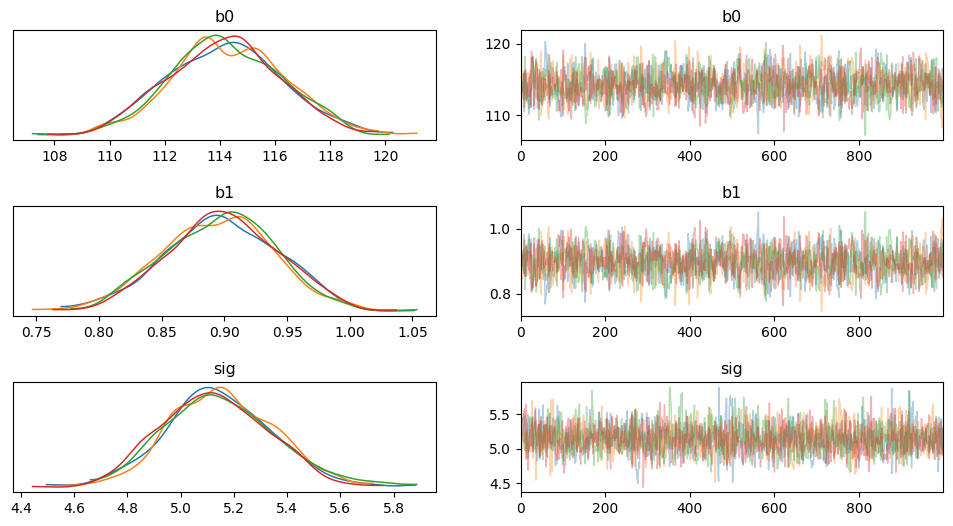

In [24]:
az.plot_trace(idata_slr, var_names = ["~mu"], compact = False);
plt.subplots_adjust(hspace=0.6)  # Increase spacing between subplots

plt.savefig("trace.png", bbox_inches='tight')
files.download("trace.png")

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

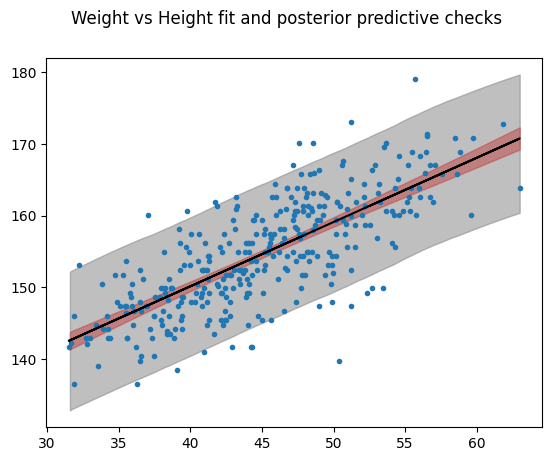

In [25]:
fig, ax = plt.subplots()

ax.plot(howell_age_18["weight"], howell_age_18["height"], "C0.")
posterior = az.extract(idata_slr, group="posterior")
pps = az.extract(idata_slr, group="posterior_predictive")["y_pred"]
μ_m = posterior["mu"].mean("sample")


ax.plot(howell_age_18["weight"], μ_m, c="k")
az.plot_hdi(howell_age_18["weight"], posterior["mu"].T, color = 'red')
az.plot_hdi(howell_age_18["weight"], pps.T, color="gray")
fig.suptitle("Weight vs Height fit and posterior predictive checks");

plt.savefig("slr.png", bbox_inches='tight')
files.download("slr.png")

Output()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

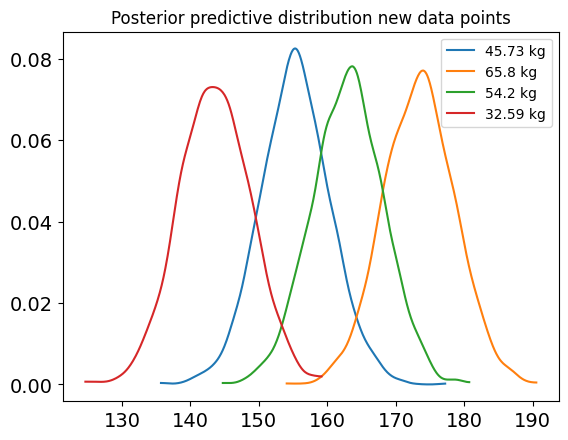

In [40]:
#c. Predicting new weight's heights
weights = (45.73, 65.8, 54.2, 32.59)

with over_18_heights:
    over_18_heights.set_data('weight_shared', weights)
    ppc = az.extract(pm.sample_posterior_predictive(idata_slr), group="posterior_predictive")

for idx, w in enumerate(weights):
    ppc_one = ppc["y_pred"].sel(weight=idx).values
    ax = az.plot_kde(ppc_one, plot_kwargs={"color": f"C{idx}"}, label=f"{w} kg");
ax.legend()
ax.set_title(f"Posterior predictive distribution new data points");

plt.savefig("pred.png", bbox_inches='tight')
files.download("pred.png")

d. Including all the data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

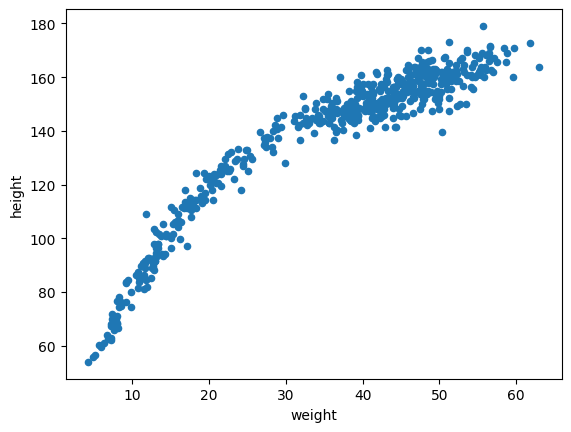

In [41]:
howell.plot(kind="scatter", x="weight", y="height");

plt.savefig("data2.png", bbox_inches='tight')
files.download("data2.png")

In [42]:
coords = {"data": np.arange(len(howell))}

with pm.Model(coords = coords) as all_heights:

  weight_shared = pm.Data("weight_shared", howell["weight"].values.astype(float), dims=["weight"])

  b0 = pm.Normal("b0", mu = howell["height"].mean(), sigma=20)
  b1 = pm.Normal("b1", mu = 0, sigma=20)
  sig = pm.HalfNormal("sig", 10)

  mu = pm.Deterministic("mu", b0 + b1 * weight_shared, dims="weight")

  y_pred = pm.Normal("y_pred", mu=mu, sigma=sig, observed = howell["height"], dims="weight")

  idata_slr2 = pm.sample(1000, chains = 4)

pm.sample_posterior_predictive(idata_slr2, model=all_heights, extend_inferencedata=True)

idata_slr2

Output()

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

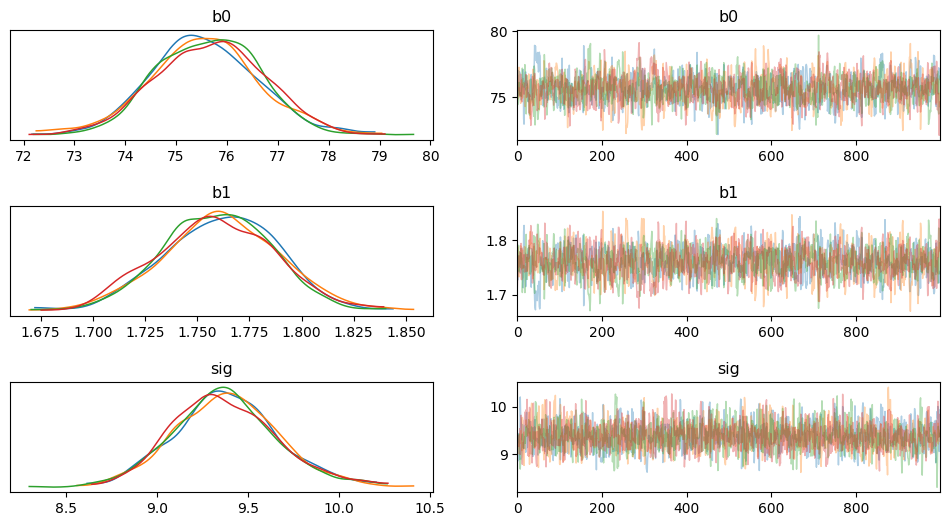

In [43]:
#trace
az.plot_trace(idata_slr2, var_names = ["~mu"], compact = False);
plt.subplots_adjust(hspace=0.6)  # Increase spacing between subplots


/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

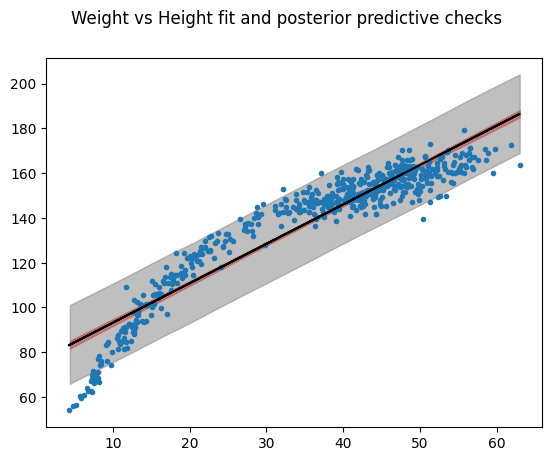

In [45]:
fig, ax = plt.subplots()

ax.plot(howell["weight"], howell["height"], "C0.")
posterior = az.extract(idata_slr2, group="posterior")
pps = az.extract(idata_slr2, group="posterior_predictive")["y_pred"]
μ_m = posterior["mu"].mean("sample")


ax.plot(howell["weight"], μ_m, c="k")
az.plot_hdi(howell["weight"], posterior["mu"].T, color = 'red')
az.plot_hdi(howell["weight"], pps.T, color="gray")
fig.suptitle("Weight vs Height fit and posterior predictive checks");

plt.savefig("slr2.png", bbox_inches='tight')
files.download("slr2.png")

f. log of the data

In [46]:
coords = {"data": np.arange(len(howell))}

with pm.Model(coords = coords) as all_heights2:

  weight_shared = pm.Data("weight_shared", howell["weight"].values.astype(float), dims=["weight"])

  b0 = pm.Normal("b0", mu = howell["height"].mean(), sigma=20)
  b1 = pm.Normal("b1", mu = 0, sigma=20)

  a0 = pm.HalfNormal("a0", sigma=10)
  a1 = pm.HalfNormal("a1", sigma=10)

  mu = pm.Deterministic("mu", b0 + b1 * np.log(weight_shared), dims="weight")
  sig = pm.Deterministic("sig", a0 + a1 * weight_shared, dims="weight")

  y_pred = pm.Normal("y_pred", mu=mu, sigma=sig, observed = howell["height"], dims="weight")

  idata_r = pm.sample(1000, chains = 4)

pm.sample_posterior_predictive(idata_r, model=all_heights2, extend_inferencedata=True)

idata_r

Output()

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

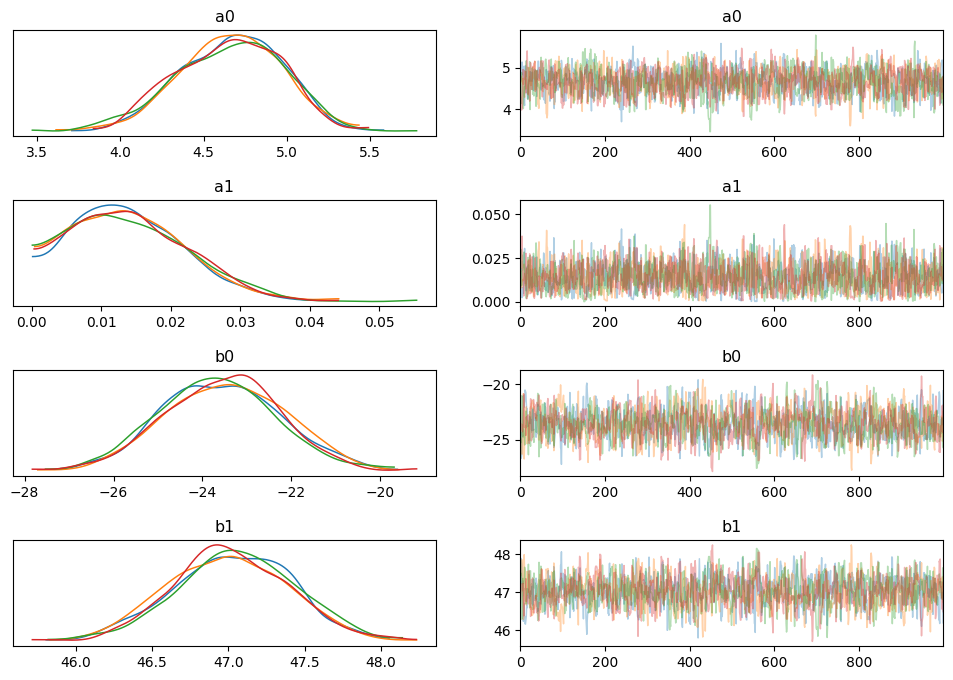

In [49]:
az.plot_trace(idata_r, var_names=["~mu", "~sig"], compact = False);
plt.subplots_adjust(hspace=0.6)  # Increase spacing between subplots

plt.savefig("t.png", bbox_inches='tight')
files.download("t.png")

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

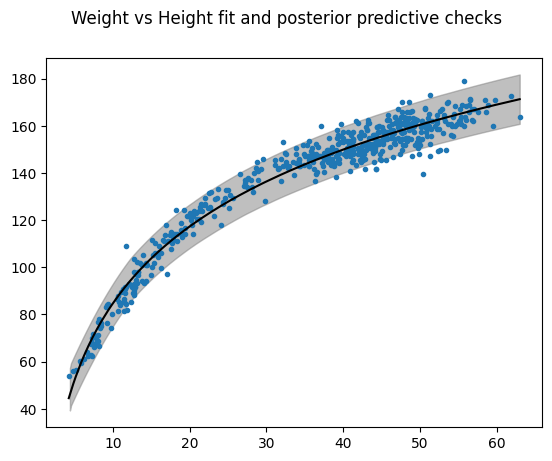

In [51]:
fig, ax = plt.subplots()

ax.plot(howell["weight"], howell["height"], "C0.")
posterior = az.extract(idata_r, group="posterior")
pps = az.extract(idata_r, group="posterior_predictive")["y_pred"]
μ_m = posterior["mu"].mean("sample")
order = np.argsort(howell["weight"].values)
ax.plot(howell["weight"][order], μ_m[order], c="k")


az.plot_hdi(howell["weight"], pps.T, color="gray")
fig.suptitle("Weight vs Height fit and posterior predictive checks");


plt.savefig("r.png", bbox_inches='tight')
files.download("r.png")

# Watermark

Please include this watermark so I can see what versions you are working with

In [ ]:
%%capture
!pip install watermark

In [ ]:
%load_ext watermark
%watermark -v -iv -w